In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm import tqdm
import os
import random
import pickle
import warnings
import gc

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (precision_recall_curve, roc_curve, make_scorer, log_loss,
                             f1_score, confusion_matrix, auc, roc_auc_score, accuracy_score)

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.pretraining import TabNetPretrainer
from torch.optim.lr_scheduler import ReduceLROnPlateau

import optuna
from optuna.samplers import TPESampler

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
RANDOM_STATE = 4158
CHUNKSIZE = 50000

with open("../Data/dtypes.pkl", 'rb') as f:
    dtypes = pickle.load(f)

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
print(f"Using PyTorch version: {torch.__version__}, Device: {DEVICE}")
%matplotlib inline

Using PyTorch version: 1.12.1+cu113, Device: cuda


In [ ]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
seed_everything(RANDOM_STATE)

In [ ]:
def viewinfo(df:pd.DataFrame) -> None:
    print(df.shape)
    print()
    df.info()
    print()
    display(df.head())

In [ ]:
print(dtypes)

{'loan_limit': 'uint64', 'loan_rate': 'float16', 'credit_score': 'uint16', 'yearly_income': 'uint64', 'income_type': 'uint8', 'employment_type': 'uint8', 'houseown_type': 'uint8', 'desired_amount': 'uint64', 'purpose': 'uint8', 'personal_rehabilitation_yn': 'bool', 'personal_rehabilitation_complete_yn': 'bool', 'existing_loan_cnt': 'uint16', 'existing_loan_amt': 'uint64', 'enter_birth': 'uint8', 'gender': 'bool', 'k_lending_rate': 'float16', 'us_lending_rate': 'float16', 'btc_price': 'uint32', 'btc_variance': 'float16', 'eth_price': 'uint32', 'eth_variance': 'float16', 'lunc_price': 'float32', 'lunc_variance': 'float16', 'Close': 'float16', 'Open': 'float16', 'High': 'float16', 'Low': 'float16', 'Volume': 'uint64', 'Change': 'float16', '실업자': 'uint16', '실업률': 'float16', '현재가계부채CSI': 'uint8', '가계부채전망CSI': 'uint8', '소비심리지수': 'float16', 'loanapply_insert_time_rank': 'uint8', 'loan_limit_avg_sub': 'float64', 'loan_rate_avg_sub': 'float16', 'bank_diversity': 'uint8', 'product_diversity': 'u

In [ ]:
gc.collect()

96

# Data Load

In [ ]:
def loaddata(fname:str, chunksize:int, dtype:dict=None, columns:list=None):  
    df = pd.DataFrame()
    for chunk in tqdm(pd.read_csv(fname, engine='python', low_memory=True, chunksize=chunksize, dtype=dtype)):
        df = pd.concat([df, chunk], axis=0)
        del chunk
        gc.collect()

    return df

In [ ]:
train = loaddata("../Data/oversample_train.csv", chunksize=CHUNKSIZE, dtype=dtypes)
valid = loaddata("../Data/master_public_data.csv", chunksize=CHUNKSIZE, dtype=dtypes)

109it [04:45,  2.62s/it]
19it [00:47,  2.50s/it]


In [ ]:
viewinfo(train)

(5437418, 72)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5437418 entries, 0 to 5437417
Data columns (total 72 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   loan_limit                           uint64 
 1   loan_rate                            float16
 2   credit_score                         uint16 
 3   yearly_income                        uint64 
 4   income_type                          uint8  
 5   employment_type                      uint8  
 6   houseown_type                        uint8  
 7   desired_amount                       uint64 
 8   purpose                              uint8  
 9   personal_rehabilitation_yn           bool   
 10  personal_rehabilitation_complete_yn  bool   
 11  existing_loan_cnt                    uint16 
 12  existing_loan_amt                    uint64 
 13  enter_birth                          uint8  
 14  gender                               bool   
 15  k_lending_rate   

,loan_limit,loan_rate,credit_score,yearly_income,income_type,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,enter_birth,gender,k_lending_rate,us_lending_rate,btc_price,btc_variance,eth_price,eth_variance,lunc_price,lunc_variance,Close,Open,High,Low,Volume,Change,실업자,실업률,현재가계부채CSI,가계부채전망CSI,소비심리지수,loanapply_insert_time_rank,loan_limit_avg_sub,loan_rate_avg_sub,bank_diversity,product_diversity,missing_value_cnt,working_year,working_month,age,holiday,weekday,hour,weekday_sin,weekday_cos,hour_sin,hour_cos,foreign,event,loan_cnt,duration,visit,segment,product_cnt,loan_limit_mean_x,loan_rate_mean_x,loan_limit_min_x,loan_rate_min_x,loan_limit_max_x,loan_rate_max_x,bank_label,loan_limit_min_y,loan_rate_min_y,loan_limit_max_y,loan_rate_max_y,loan_limit_mean_y,loan_rate_mean_y,product_label,is_applied
0,14000000,9.000000,710,28000000,0,3,3,40000000,7,False,False,4,67000000,29,True,1.50,1.00,39120756,-0.026001,2640599,-0.080688,0.000322,-0.999512,2550.0,2570.0,2592.0,2546.0,900330000,-0.016296,76,2.300781,102,101,94.0000,10,-4.161290e+06,-1.806641,22,31,0,2,9,31,False,4,11,-0.433838,-0.900879,0.258789,-0.965820,False,10,5,141,1,1,4,1.668727e+07,10.851562,1000000.0,5.898438,100000000.0,16.296875,2,6000000.0,9.000000,20000000.0,10.000000,1.355632e+07,9.054688,1,False
1,9000000,6.601562,580,36000000,1,3,3,3000000,7,False,False,5,78000000,49,False,1.50,0.50,50162048,-0.027496,3790690,-0.029800,81.518517,-0.071899,2716.0,2720.0,2720.0,2702.0,665350000,0.000100,47,1.599609,102,101,91.8125,1,0.000000e+00,-0.657227,7,7,2,2,13,51,False,4,4,-0.433838,-0.900879,0.866211,0.500000,True,6,2,354,1,4,4,1.668727e+07,10.851562,1000000.0,5.898438,100000000.0,16.296875,2,2000000.0,6.500000,20000000.0,10.000000,1.212646e+07,6.613281,1,False
2,1000000,12.500000,780,25000000,0,3,3,40000000,7,False,False,3,237000000,33,False,1.25,0.25,48605860,0.003300,3289621,0.013397,87.549965,0.050507,2714.0,2736.0,2736.0,2702.0,765680000,-0.012199,65,3.099609,103,102,93.8125,1,-8.391304e+06,1.521484,20,23,2,2,16,35,True,6,22,-0.781738,0.623535,-0.500000,0.866211,False,9,3,301,1,6,4,1.668727e+07,10.851562,1000000.0,5.898438,100000000.0,16.296875,2,1000000.0,5.898438,100000000.0,16.296875,2.030726e+07,13.828125,0,False
3,40000000,7.898438,990,40000000,5,3,2,270000000,3,False,False,1,55000000,35,True,1.50,1.00,37052276,-0.055389,2468705,-0.083191,0.000061,-0.195312,2626.0,2634.0,2644.0,2618.0,870270000,0.002100,65,1.700195,103,100,92.5000,7,1.133333e+07,-2.546875,18,21,2,15,165,50,False,3,14,0.433838,-0.900879,-0.500000,-0.866211,False,10,5,503,1,1,7,2.464846e+07,12.179688,0.0,4.800781,150000000.0,19.906250,2,0.0,4.800781,150000000.0,19.906250,2.418366e+07,12.664062,0,False
4,6000000,15.796875,910,24000000,0,3,2,10000000,7,False,False,12,111000000,40,False,1.75,1.00,39541500,0.057404,2493979,0.082214,0.000127,0.234253,2670.0,2662.0,2672.0,2654.0,469800000,0.012001,71,2.699219,102,101,93.3125,14,-7.500000e+06,4.148438,26,36,1,9,100,49,False,1,18,0.781738,0.623535,-1.000000,-0.000000,False,2,0,900,1,3,2,1.861316e+07,13.226562,0.0,7.199219,50000000.0,19.906250,2,0.0,13.398438,50000000.0,19.906250,2.121015e+07,15.804688,0,False


In [ ]:
viewinfo(valid)

(924301, 72)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924301 entries, 0 to 924300
Data columns (total 72 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_limit                           924301 non-null  uint64 
 1   loan_rate                            924301 non-null  float16
 2   credit_score                         924301 non-null  uint16 
 3   yearly_income                        924301 non-null  uint64 
 4   income_type                          924301 non-null  uint8  
 5   employment_type                      924301 non-null  uint8  
 6   houseown_type                        924301 non-null  uint8  
 7   desired_amount                       924301 non-null  uint64 
 8   purpose                              924301 non-null  uint8  
 9   personal_rehabilitation_yn           924301 non-null  bool   
 10  personal_rehabilitation_complete_yn  924301 non-null  bool   
 11 

,loan_limit,loan_rate,credit_score,yearly_income,income_type,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,enter_birth,gender,k_lending_rate,us_lending_rate,btc_price,btc_variance,eth_price,eth_variance,lunc_price,lunc_variance,Close,Open,High,Low,Volume,Change,실업자,실업률,현재가계부채CSI,가계부채전망CSI,소비심리지수,loanapply_insert_time_rank,loan_limit_avg_sub,loan_rate_avg_sub,bank_diversity,product_diversity,missing_value_cnt,working_year,working_month,age,holiday,weekday,hour,weekday_sin,weekday_cos,hour_sin,hour_cos,foreign,event,loan_cnt,duration,visit,segment,product_cnt,loan_limit_mean_x,loan_rate_mean_x,loan_limit_min_x,loan_rate_min_x,loan_limit_max_x,loan_rate_max_x,bank_label,loan_limit_min_y,loan_rate_min_y,loan_limit_max_y,loan_rate_max_y,loan_limit_mean_y,loan_rate_mean_y,product_label,is_applied
0,3000000,9.898438,680,30000000,2,1,2,23000000,6,False,False,8,251000000,43,True,1.25,0.5,52932200,-0.015701,4000174,0.001300,94.531815,-0.087280,2700.0,2706.0,2712.0,2686.0,948360000,0.001700,62,1.599609,103,101,91.8125,5,-5.200000e+06,-4.500000,10,10,2,3,23,46,False,5,18,-0.975098,-0.222534,-1.000000,-0.000000,False,6,3,186,1,4,7,2.464846e+07,12.179688,0.0,4.800781,150000000.0,19.90625,2,0.0,4.800781,150000000.0,19.906250,2.418366e+07,12.664062,0,False
1,41000000,10.703125,777,40000000,0,3,2,140000000,4,False,False,2,62199999,38,False,1.25,0.5,57062564,0.008102,4311752,0.002399,116.432358,0.031204,2758.0,2730.0,2758.0,2722.0,1020000000,0.006599,47,1.599609,102,101,91.8125,16,8.256410e+06,-1.407227,29,39,5,13,142,51,False,1,22,0.781738,0.623535,-0.500000,0.866211,True,9,3,300,1,1,2,3.244987e+07,12.773438,3000000.0,7.199219,150000000.0,17.50000,2,3000000.0,7.199219,150000000.0,17.500000,3.819088e+07,11.851562,0,False
2,2000000,19.406250,880,3000000,0,3,0,50000000,4,False,False,1,39400000,26,False,1.25,0.5,57062564,0.008102,4311752,0.002399,116.432358,0.031204,2758.0,2730.0,2758.0,2722.0,1020000000,0.006599,137,6.398438,105,103,91.1875,15,-1.233333e+07,6.640625,30,39,3,2,13,28,False,1,8,0.781738,0.623535,0.866211,-0.500000,False,8,4,284,1,6,1,4.320983e+06,16.437500,2000000.0,4.500000,15000000.0,19.90625,2,2000000.0,4.500000,15000000.0,19.906250,4.320983e+06,16.437500,0,False
3,3000000,14.796875,850,20000000,3,1,3,30000000,7,False,False,1,13000000,42,True,1.50,1.0,37914376,0.002899,2492835,-0.011597,0.000069,0.095581,2618.0,2622.0,2630.0,2602.0,712610000,0.004398,65,1.700195,103,100,90.6875,1,-1.333333e+06,0.933105,9,9,3,2,14,44,False,3,14,0.433838,-0.900879,-0.500000,-0.866211,False,12,3,376,2,4,14,1.766154e+07,14.460938,1000000.0,5.000000,200000000.0,19.90625,2,1000000.0,10.601562,65000000.0,19.906250,4.057580e+06,14.476562,0,False
4,11000000,14.898438,652,42000000,0,3,3,30000000,6,False,False,4,76200000,39,True,1.50,0.5,49672932,-0.001200,3676750,-0.006599,90.530510,0.013901,2704.0,2704.0,2708.0,2690.0,1240000000,-0.008598,62,1.599609,101,100,93.0000,6,-1.291837e+07,1.983398,34,49,4,3,29,42,False,0,11,0.000000,1.000000,0.258789,-0.965820,False,8,5,214,1,0,4,1.327673e+07,14.156250,0.0,8.000000,30000000.0,19.50000,2,0.0,14.000000,30000000.0,19.296875,1.174694e+07,16.109375,0,False


# Preprocessing

In [ ]:
# train.drop('holiday', axis=1, inplace=True)
# valid.drop('holiday', axis=1, inplace=True)

In [ ]:
cat_feats = ['income_type', 'employment_type', 'houseown_type', 'purpose', 'personal_rehabilitation_yn', 'personal_rehabilitation_complete_yn', 
             'gender', 'bank_diversity', 'product_diversity', 'holiday', 'weekday', 'foreign', 'segment', 'bank_label', 'product_label']
cat_idxs = [i for i, col in enumerate(train.columns.values) if col in cat_feats]

In [ ]:
for col in train.columns.values:
    if train[col].dtype == 'bool':
        train[col] = train[col].astype('uint8')
    if valid[col].dtype == 'bool':
        valid[col] = valid[col].astype('uint8')

In [ ]:
for col in cat_feats:
    if train[col].min() != 0:
        train[col] -= train[col].min()
    if valid[col].min() != 0:
        valid[col] -= valid[col].min()

In [ ]:
cat_dims = [train[col].nunique() for col in cat_feats]

In [ ]:
print(cat_idxs)
print(cat_dims)

[4, 5, 6, 8, 9, 10, 14, 37, 38, 43, 44, 50, 55, 63, 70]
[6, 4, 4, 8, 2, 2, 2, 56, 79, 2, 7, 2, 7, 3, 2]


# Evaluation Metric

In [ ]:
class F1Score(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True
    
    def __call__(self, y_true, y_score):
        y_score = (y_score[:, 1] >= 0.5).astype(np.uint8)
        return f1_score(y_true, y_score)

# Pretraining

## Split X, y

In [ ]:
X_train = train.drop('is_applied', axis=1)
y_train = train['is_applied']

X_valid = valid.drop('is_applied', axis=1)
y_valid = valid['is_applied']

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=RANDOM_STATE, stratify=y_train)

In [ ]:
print(f"Unique categories")
for col in cat_feats:
    print(f"\ttrain {col} -> {np.sort(X_tr[col].unique())}", end='')
    print(f"\tvalid {col} -> {np.sort(X_val[col].unique())}")

Unique categories
	train income_type -> [0 1 2 3 4 5]	valid income_type -> [0 1 2 3 4 5]
	train employment_type -> [0 1 2 3]	valid employment_type -> [0 1 2 3]
	train houseown_type -> [0 1 2 3]	valid houseown_type -> [0 1 2 3]
	train purpose -> [0 1 2 3 4 5 6 7]	valid purpose -> [0 1 2 3 4 5 6 7]
	train personal_rehabilitation_yn -> [0 1]	valid personal_rehabilitation_yn -> [0 1]
	train personal_rehabilitation_complete_yn -> [0 1]	valid personal_rehabilitation_complete_yn -> [0 1]
	train gender -> [0 1]	valid gender -> [0 1]
	train bank_diversity -> [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]	valid bank_diversity -> [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]
	train product_diversity -> [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15

## Hyper-parameters

In [ ]:
## constant values for hyper-parameter
BATCH_SIZE = 2**11
GHOST_BATCH = 2**7
# N_D = N_A = 12
MAX_EPOCH = 100
# MASK_TYPE = "entmax"
N_STEPS = 5
LR = 0.01
PATIENCE = 8
# PRETRAINING_RATIO = 0.7
NROWS = 1

## Pretrain model

In [ ]:
tabnet_params = dict(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    seed=RANDOM_STATE,
    optimizer_params=dict(lr=LR), 
    # scheduler_params=dict(mode="min", patience=5, min_lr=1e-5, factor=0.9),
    # scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    device_name=str(DEVICE)
)

pretrainer = TabNetPretrainer(**tabnet_params)

pretrainer.fit(
    X_train=X_train.values, eval_set=[X_valid.values], 
    max_epochs=MAX_EPOCH, 
    patience=PATIENCE, 
    batch_size=BATCH_SIZE, 
    virtual_batch_size=GHOST_BATCH, 
    num_workers=0, 
    drop_last=False, 
    # pretraining_ratio=PRETRAINING_RATIO
)

epoch 0  | loss: 109.95198| val_0_unsup_loss_numpy: 75.85262298583984|  0:03:53s
epoch 1  | loss: 7.72789 | val_0_unsup_loss_numpy: 7.831409931182861|  0:07:44s
epoch 2  | loss: 5.05535 | val_0_unsup_loss_numpy: 6.36890983581543|  0:11:34s
epoch 3  | loss: 4.18821 | val_0_unsup_loss_numpy: 4.250140190124512|  0:15:25s
epoch 4  | loss: 3.65581 | val_0_unsup_loss_numpy: 3.586590051651001|  0:19:20s
epoch 5  | loss: 3.67806 | val_0_unsup_loss_numpy: 3.0711100101470947|  0:23:13s
epoch 6  | loss: 3.93225 | val_0_unsup_loss_numpy: 3.0656700134277344|  0:27:05s
epoch 7  | loss: 3.58761 | val_0_unsup_loss_numpy: 9.622770309448242|  0:30:56s
epoch 8  | loss: 3.76628 | val_0_unsup_loss_numpy: 3.355340003967285|  0:34:47s
epoch 9  | loss: 3.29962 | val_0_unsup_loss_numpy: 3.016160011291504|  0:38:33s
epoch 10 | loss: 3.32598 | val_0_unsup_loss_numpy: 3.1162500381469727|  0:42:20s
epoch 11 | loss: 3.19814 | val_0_unsup_loss_numpy: 3.0869998931884766|  0:46:12s
epoch 12 | loss: 3.25716 | val_0_uns

## Plot results

In [ ]:
pretrain_explain_matrix, pretrain_masks = pretrainer.explain(X_valid.values)

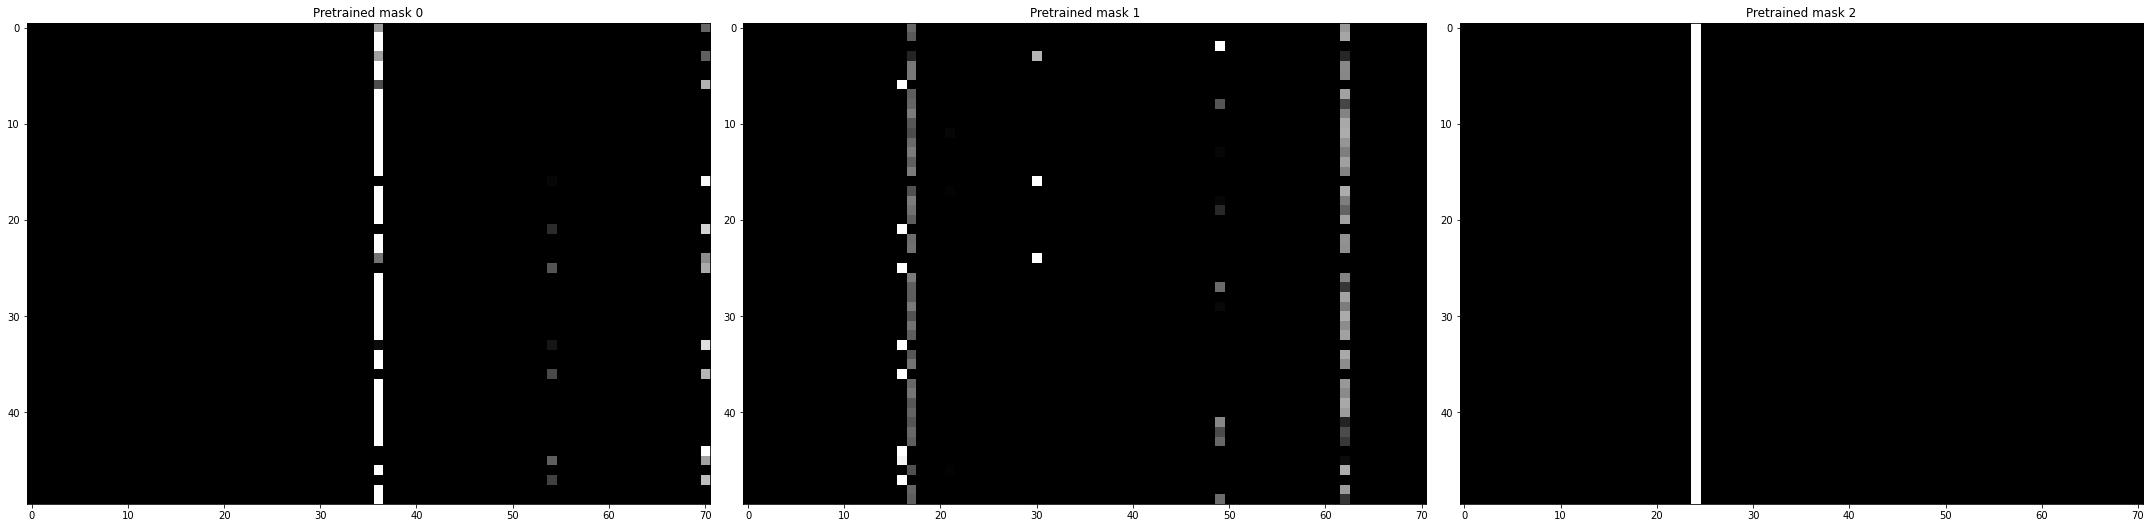

In [ ]:
plt.figure(figsize=(30, 10))
for key in pretrain_masks:
    plt.subplot(int(f"{NROWS}{len(pretrain_masks)//NROWS}{key+1}"))
    plt.imshow(pretrain_masks[key][:50], cmap='gray')
    # plt.axis('off')
    plt.title(f"Pretrained mask {key}")
plt.tight_layout()
plt.show()

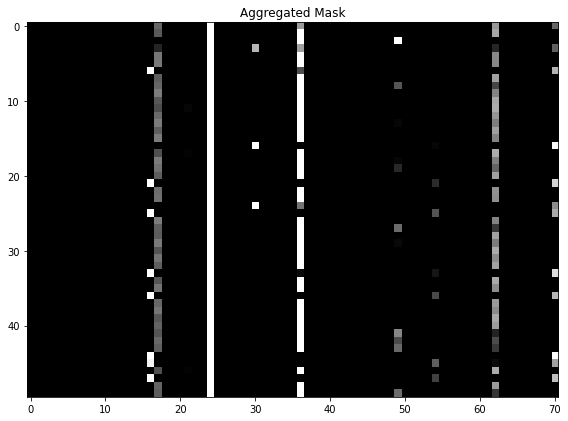

In [ ]:
mask_agg = np.zeros(shape=pretrain_masks[0].shape)
for key in pretrain_masks:
    mask_agg += pretrain_masks[key]
mask_agg /= len(pretrain_masks)

plt.figure(figsize=(8, 12))
plt.imshow(mask_agg[:50], cmap='gray')
plt.title(f"Aggregated Mask")
# plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
del pretrain_explain_matrix, pretrain_masks, mask_agg
gc.collect()

9313

## Save Model

In [ ]:
with open("../Model/pretrainer_smote_default.pkl", 'wb') as f:
    pickle.dump(pretrainer, f, protocol=pickle.HIGHEST_PROTOCOL)

Successfully saved model at /content/drive/MyDrive/projects/빅콘테스트/models/pretrainer_smote_default.zip


'/content/drive/MyDrive/projects/빅콘테스트/models/pretrainer_smote_default.zip'

# Supervised Training

## With Pretraining

### Load Pretrained Model

In [ ]:
with open("../Model/pretrainer_smote_default.pkl", 'rb') as f:
    pretrainer = pickle.load(f)

In [ ]:
gc.collect()

48

### Model Implementation

In [ ]:
clf = TabNetClassifier(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    seed=RANDOM_STATE,
    optimizer_params=dict(lr=LR), 
    # scheduler_params=dict(mode="min", patience=5, min_lr=1e-5, factor=0.9),
    # scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    device_name=str(DEVICE)
)

In [ ]:
%time
clf.fit(
    X_train=X_train.values, 
    y_train=y_train.values,
    eval_set=[(X_train.values, y_train.values), (X_valid.values, y_valid.values)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss', 'f1'],
    max_epochs=MAX_EPOCH, 
    batch_size=BATCH_SIZE, 
    virtual_batch_size=GHOST_BATCH,
    patience=8,
    num_workers=0, 
    drop_last=False,
    from_unsupervised=pretrainer
) 

epoch 0  | loss: 0.2201  | train_logloss: 0.12724 | train_f1: 0.94852 | valid_logloss: 0.17169 | valid_f1: 0.26205 |  0:04:36s
epoch 1  | loss: 0.12664 | train_logloss: 0.11042 | train_f1: 0.95436 | valid_logloss: 0.16028 | valid_f1: 0.27237 |  0:09:09s
epoch 2  | loss: 0.11757 | train_logloss: 0.10969 | train_f1: 0.95514 | valid_logloss: 0.16872 | valid_f1: 0.26783 |  0:13:38s
epoch 3  | loss: 0.1138  | train_logloss: 0.11996 | train_f1: 0.94898 | valid_logloss: 0.15345 | valid_f1: 0.18282 |  0:18:16s
epoch 4  | loss: 0.1108  | train_logloss: 0.12375 | train_f1: 0.94948 | valid_logloss: 0.20403 | valid_f1: 0.30996 |  0:22:52s
epoch 5  | loss: 0.10805 | train_logloss: 0.10003 | train_f1: 0.95916 | valid_logloss: 0.1509  | valid_f1: 0.26406 |  0:27:24s
epoch 6  | loss: 0.10528 | train_logloss: 0.10049 | train_f1: 0.95935 | valid_logloss: 0.15557 | valid_f1: 0.29124 |  0:31:54s
epoch 7  | loss: 0.10382 | train_logloss: 0.10331 | train_f1: 0.95722 | valid_logloss: 0.15162 | valid_f1: 0.28

In [ ]:
gc.collect()

22

### Plot Evaluation Metrics

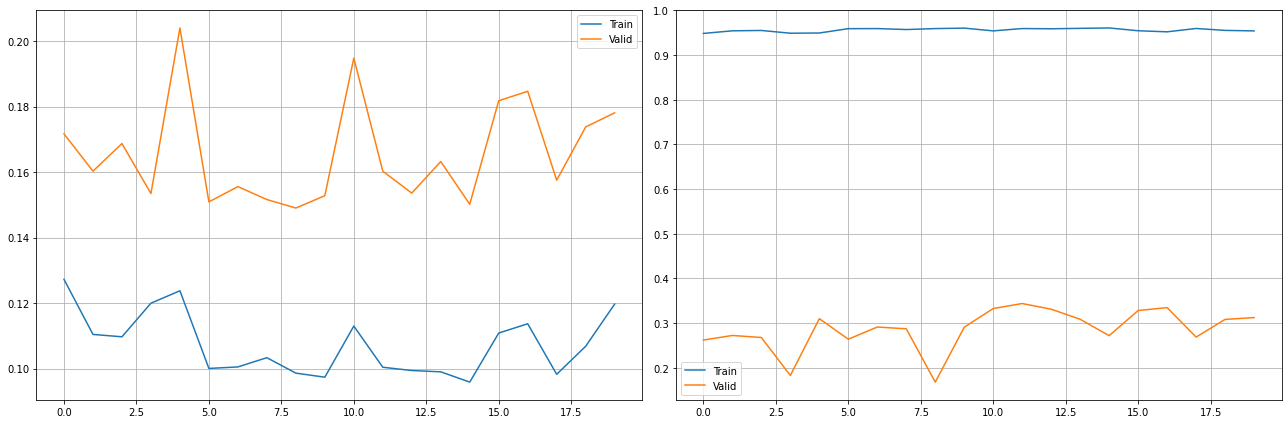

In [ ]:
plt.figure(figsize=(18, 6))

plt.subplot(121)
plt.plot(clf.history['train_logloss'], label="Train")
plt.plot(clf.history['valid_logloss'], label="Valid")
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot(clf.history['train_f1'], label="Train")
plt.plot(clf.history['valid_f1'], label="Valid")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Plot Feature Importances

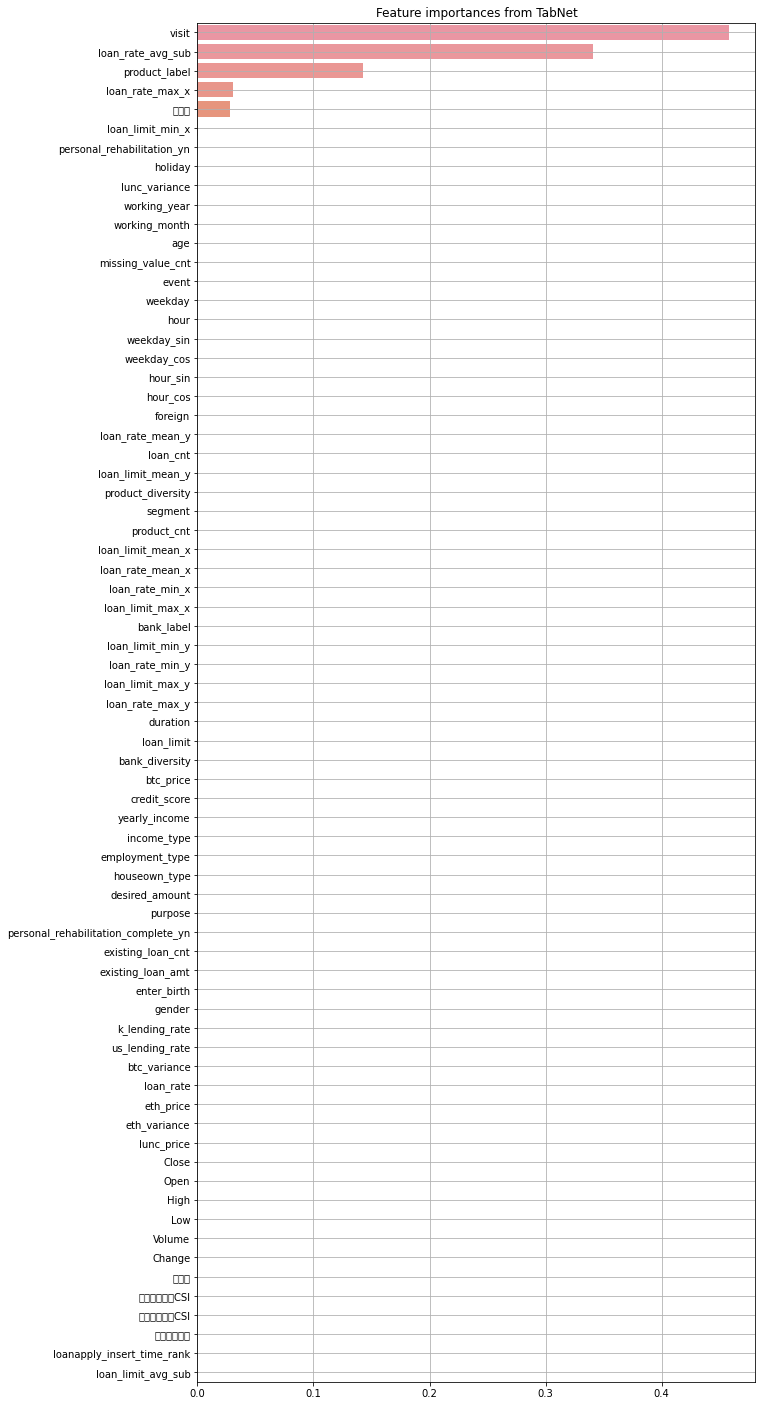

In [ ]:
imp = pd.Series(data=clf.feature_importances_, index=X_train.columns.values).sort_values(ascending=False)

plt.figure(figsize=(10, 25))
sns.barplot(x=imp, 
            y=imp.index)
plt.title("Feature importances from TabNet")
plt.grid(True)
plt.show()

### Save Model

In [ ]:
try:
    clf.save_model("../Model/clf_smote_pretrain_1")
    print()
except:
    with open("../Model/clf_smote_pretrain_1.pkl", "wb") as f:
        pickle.dump(clf, f, protocol=pickle.HIGHEST_PROTOCOL)